**Table of contents**<a id='toc0_'></a>    
- [Be My Guest - Recruit Restaurant EDA](#toc1_)    
  - [Load Data](#toc1_1_)    
  - [EDA](#toc1_2_)    
    - [File Structure & Content Overview](#toc1_2_1_)    
      - [Air Reserve](#toc1_2_1_1_)    
      - [HPG Reserve](#toc1_2_1_2_)    
      - [Air Visits](#toc1_2_1_3_)    
      - [Air Store](#toc1_2_1_4_)    
      - [HPG Store](#toc1_2_1_5_)    
      - [Holidays](#toc1_2_1_6_)    
      - [Store ID Relation](#toc1_2_1_7_)    
      - [Test Data](#toc1_2_1_8_)    
    - [Reformat Features](#toc1_2_2_)    
    - [Feature Visualizations](#toc1_2_3_)    
      - [Air Visits](#toc1_2_3_1_)    
      - [Air Reservations](#toc1_2_3_2_)    
      - [HPG Reservations](#toc1_2_3_3_)    
    - [Spatial Analysis](#toc1_2_4_)    
      - [Air Store](#toc1_2_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Be My Guest - Recruit Restaurant EDA](#toc0_)

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import calendar
import folium
from folium.plugins import MarkerCluster,FastMarkerCluster

## <a id='toc1_1_'></a>[Load Data](#toc0_)

In [125]:
air_reserve_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_reserve.csv')
air_visits_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
air_store_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_store_info.csv')
hpg_reserve_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
hpg_store_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
holidays_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/date_info.csv')
store_ids_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/store_id_relation.csv')
test_df = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/sample_submission.csv')

The data comes from two separate sites:

* Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
* AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

## <a id='toc1_2_'></a>[EDA](#toc0_)

### <a id='toc1_2_1_'></a>[File Structure & Content Overview](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Air Reserve](#toc0_)


This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

air_store_id - the restaurant's id in the air system\
visit_datetime - the time of the reservation\
reserve_datetime - the time the reservation was made\
reserve_visitors - the number of visitors for that reservation

In [126]:
air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [127]:
air_reserve_df.describe()

,reserve_visitors
count,92378.000000
mean,4.481749
std,4.919669
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


In [128]:
print("Max air reserve visit datetime: ", air_reserve_df['visit_datetime'].max())
print("Min air reserve visit datetime: ", air_reserve_df['visit_datetime'].min())
print("Max air reserve visitors: ", air_reserve_df['reserve_visitors'].max())
print("Min air reserve visitors: ", air_reserve_df['reserve_visitors'].min())

Max air reserve visit datetime:  2017-05-31 21:00:00
Min air reserve visit datetime:  2016-01-01 19:00:00
Max air reserve visitors:  100
Min air reserve visitors:  1


#### <a id='toc1_2_1_2_'></a>[HPG Reserve](#toc0_)


This file contains reservations made in the hpg system.

hpg_store_id - the restaurant's id in the hpg system\
visit_datetime - the time of the reservation\
reserve_datetime - the time the reservation was made\
reserve_visitors - the number of visitors for that reservation

In [129]:
hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [130]:
hpg_reserve_df.describe()

,reserve_visitors
count,2.000320e+06
mean,5.073785e+00
std,5.416172e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.000000e+02


In [131]:
print("Max hpg reserve visit datetime: ", hpg_reserve_df['visit_datetime'].max())
print("Min hpg reserve visit datetime: ", hpg_reserve_df['visit_datetime'].min())
print("Max hpg reserve visitors: ", hpg_reserve_df['reserve_visitors'].max())
print("Min hpg reserve visitors: ", hpg_reserve_df['reserve_visitors'].min())

Max hpg reserve visit datetime:  2017-05-31 23:00:00
Min hpg reserve visit datetime:  2016-01-01 11:00:00
Max hpg reserve visitors:  100
Min hpg reserve visitors:  1


#### <a id='toc1_2_1_3_'></a>[Air Visits](#toc0_)

This file contains historical visit data for the air restaurants.

air_store_id
visit_date - the date
visitors - the number of visitors to the restaurant on the date

In [132]:
air_visits_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [133]:
air_visits_df.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


In [134]:
print("Max Air Visits datetime: ", air_visits_df['visit_date'].max())
print("Min Air Visits datetime: ", air_visits_df['visit_date'].min())
print("Max reserve visitors: ", air_visits_df['visitors'].max())
print("Min reserve visitors: ", air_visits_df['visitors'].min())

Max Air Visits datetime:  2017-04-22
Min Air Visits datetime:  2016-01-01
Max reserve visitors:  877
Min reserve visitors:  1


#### <a id='toc1_2_1_4_'></a>[Air Store](#toc0_)

This file contains information about select air restaurants. Column names and contents are self-explanatory.

air_store_id\
air_genre_name\
air_area_name\
latitude\
longitude

In [135]:
air_store_df.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [136]:
air_store_df.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


#### <a id='toc1_2_1_5_'></a>[HPG Store](#toc0_)

This file contains reservations made in the hpg system.

hpg_store_id - the restaurant's id in the hpg system\
visit_datetime - the time of the reservation\
reserve_datetime - the time the reservation was made\
reserve_visitors - the number of visitors for that reservation

In [137]:
hpg_store_df.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [138]:
hpg_store_df.describe()

,latitude,longitude
count,4690.000000,4690.000000
mean,35.810261,137.675816
std,2.138755,3.197233
min,33.311645,130.339313
25%,34.692109,135.498859
50%,35.659214,139.495733
75%,35.703381,139.737998
max,43.774846,143.714585


#### <a id='toc1_2_1_6_'></a>[Holidays](#toc0_)

This file gives basic information about the calendar dates in the dataset.

calendar_date\
day_of_week\
holiday_flg - is the day a holiday in Japan

In [139]:
holidays_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [140]:
holidays_df.describe()

,holiday_flg
count,517.000000
mean,0.067698
std,0.251471
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [141]:
print("Max calendar date: ", holidays_df['calendar_date'].max())
print("Min calendar date: ", holidays_df['calendar_date'].min())
print("Number of holidays: ", holidays_df['holiday_flg'].sum())

Max calendar date:  2017-05-31
Min calendar date:  2016-01-01
Number of holidays:  35


#### <a id='toc1_2_1_7_'></a>[Store ID Relation](#toc0_)

This file allows you to join select restaurants that have both the air and hpg system.\

hpg_store_id\
air_store_id

In [142]:
store_ids_df.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [143]:
store_ids_df.describe()

,air_store_id,hpg_store_id
count,150,150
unique,150,150
top,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
freq,1,1


#### <a id='toc1_2_1_8_'></a>[Test Data](#toc0_)

In [144]:
test_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [145]:
test_df.describe()

,visitors
count,32019.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### <a id='toc1_2_2_'></a>[Reformat Features](#toc0_)

In [146]:
air_visits_df['visit_date'] = pd.to_datetime(air_visits_df['visit_date'], format="%Y/%m/%d")
air_reserve_df['visit_datetime'] = pd.to_datetime(air_reserve_df['visit_datetime'], format="%Y/%m/%d %H:%M:%S")
air_reserve_df['reserve_datetime'] = pd.to_datetime(air_reserve_df['reserve_datetime'], format="%Y/%m/%d %H:%M:%S")
hpg_reserve_df['visit_datetime'] = pd.to_datetime(hpg_reserve_df['visit_datetime'], format="%Y/%m/%d %H:%M:%S")
hpg_reserve_df['reserve_datetime'] = pd.to_datetime(hpg_reserve_df['reserve_datetime'], format="%Y/%m/%d %H:%M:%S")
air_store_df['air_genre_name'] = pd.Categorical(air_store_df['air_genre_name'])
hpg_store_df['hpg_genre_name'] = pd.Categorical(hpg_store_df['hpg_genre_name'])
holidays_df['calendar_date'] = pd.to_datetime(holidays_df['calendar_date'], format="%Y/%m/%d")
holidays_df['holiday_flg'] = holidays_df['holiday_flg'].astype('bool')
holidays_df['day_of_week'] = holidays_df['day_of_week'].astype('str')

### <a id='toc1_2_3_'></a>[Feature Visualizations](#toc0_)

#### <a id='toc1_2_3_1_'></a>[Air Visits](#toc0_)

In [147]:
#Group the data by its visit date since there are multiple instances of the column & combine the visitors column by summing.
air_visits_date_group = air_visits_df.groupby('visit_date', as_index=False).agg({'visitors': 'sum'})
#p1 = air_visits_df.groupby('visit_date', as_index=False)['visitors'].sum() #both are equivalent

In [148]:
air_visits_date_group.head()

,visit_date,visitors
0,2016-01-01,1033
1,2016-01-02,1764
2,2016-01-03,2368
3,2016-01-04,3326
4,2016-01-05,3927


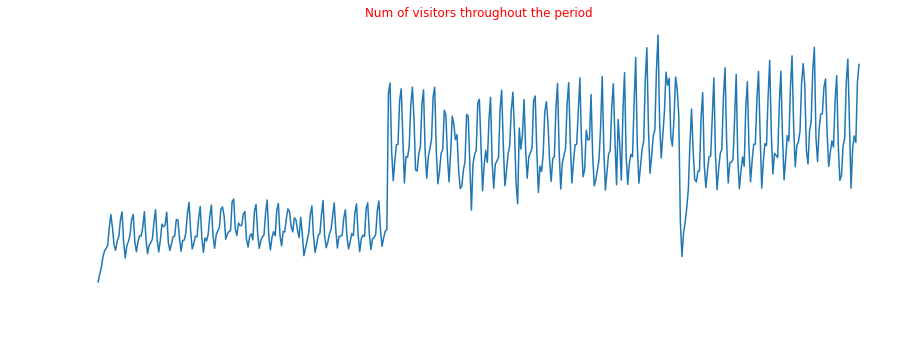

In [149]:

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (15,5)
sns.lineplot(x='visit_date', y='visitors', data=air_visits_date_group)
plt.xticks(rotation=50)
title_object = plt.title("Num of visitors throughout the period")
plt.setp(title_object, color='r') 
plt.show()

In [150]:
air_visits_df

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


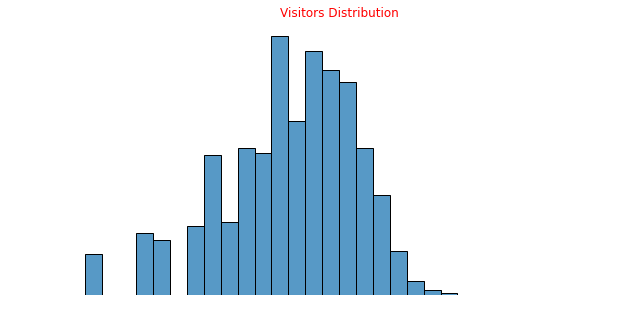

In [151]:
plt.rcParams["figure.figsize"] = (10,5)
#since the visitors column has a very wide range of values, we'll visualize the distribution in a logarithmic scale.
air_visits_df['visitors_logarithmic'] = np.log2(air_visits_df['visitors'])
sns.histplot(x='visitors_logarithmic', data=air_visits_df, bins=30)
title_object = plt.title("Visitors Distribution")
plt.setp(title_object, color='r')
plt.show()

In [152]:
air_visits_df['wday'] = air_visits_df['visit_date'].dt.weekday + 1 #find the day of the week based on the date. Starts from 1 = Monday to 7 for Sunday
air_visits_wday_group = air_visits_df.groupby('wday', as_index=False).agg({'visitors': 'median'}) #group the df by the day of the week and get the median num of visitors on each day.
weekday_dict = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
air_visits_wday_group['wday'] = air_visits_wday_group['wday'].replace(weekday_dict) #maps the numbers to day name.


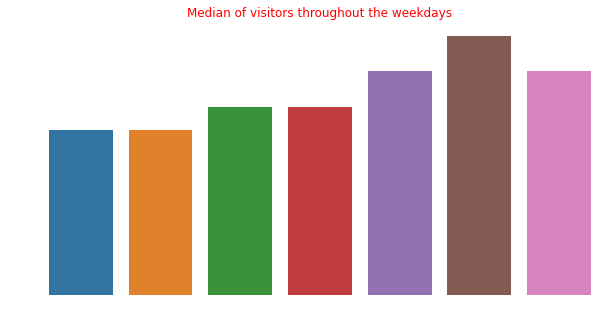

In [153]:
sns.barplot(data=air_visits_wday_group, x='wday', y='visitors')
title_object = plt.title("Median of visitors throughout the weekdays")
plt.setp(title_object, color='r') 
plt.show()

In [154]:
air_visits_df['month'] = air_visits_df['visit_date'].dt.month
air_visits_month_group = air_visits_df.groupby('month', as_index=False).agg({'visitors':'median'})
air_visits_month_group['month'] = air_visits_month_group['month'].apply(lambda x: calendar.month_abbr[x])

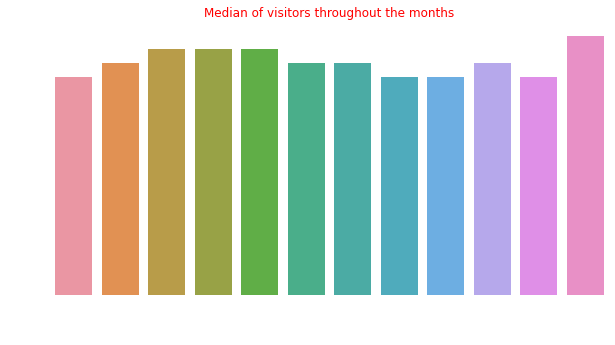

In [155]:
sns.barplot(data=air_visits_month_group, x='month', y='visitors')
title_object = plt.title("Median of visitors throughout the months")
plt.setp(title_object, color='r') 
plt.xticks(rotation=50)
plt.show()

From the visualizations above, we observe that 
* There might have been new restaurants added to the DB as we see a sudden increase in visitors activity around July 2016.
* There is also a periodic pattern that probably corresponds to weekly cycle.
* Friday and the weekends have the highest number of visitors while  Mon and Tue has the lowest. This conforms to our expectations and common sense.
* Mar to May seems to be a consistently busy period for the restaurant while the num of visitors peak at Dec. Perhaps due to holidays, bonuses, sales, etc.

In [156]:
air_visits_df

,air_store_id,visit_date,visitors,visitors_logarithmic,wday,month
0,air_ba937bf13d40fb24,2016-01-13,25,4.643856,3,1
1,air_ba937bf13d40fb24,2016-01-14,32,5.000000,4,1
2,air_ba937bf13d40fb24,2016-01-15,29,4.857981,5,1
3,air_ba937bf13d40fb24,2016-01-16,22,4.459432,6,1
4,air_ba937bf13d40fb24,2016-01-18,6,2.584963,1,1
...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,2.584963,2,4
252104,air_24e8414b9b07decb,2017-04-19,6,2.584963,3,4
252105,air_24e8414b9b07decb,2017-04-20,7,2.807355,4,4
252106,air_24e8414b9b07decb,2017-04-21,8,3.000000,5,4


In [157]:
air_visits_filtered = air_visits_df.loc[(air_visits_df['visit_date'] > "2016-04-15") & (air_visits_df['visit_date'] < "2016-06-15")]
air_visits_filtered_grouped = air_visits_filtered.groupby('visit_date', as_index=False).agg({'visitors':'sum'})

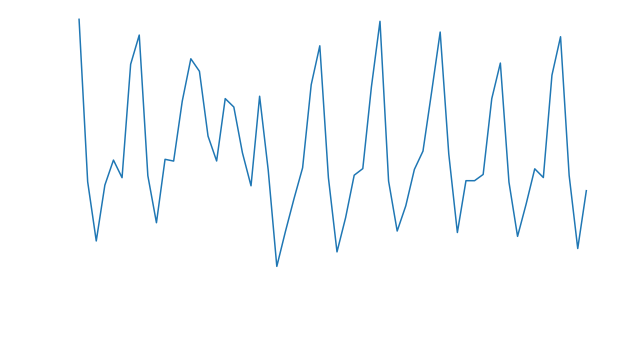

In [158]:
sns.lineplot(x='visit_date', y='visitors', data=air_visits_filtered_grouped)
plt.xticks(rotation=50)
plt.xlabel('Visualizing Golden Week (Apr 29 to May 5)')
plt.show()

Notice that the same pattern occurs everywhere except during the Golden Week where there was no significant dip in the num of visitors.

#### <a id='toc1_2_3_2_'></a>[Air Reservations](#toc0_)

In [159]:
air_reserve_df

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [160]:
air_reserve_df['visit_date'] = air_reserve_df['visit_datetime'].dt.date
air_reserve_visit_date_grouped = air_reserve_df.groupby('visit_date', as_index=False).agg({'reserve_visitors':'sum'})

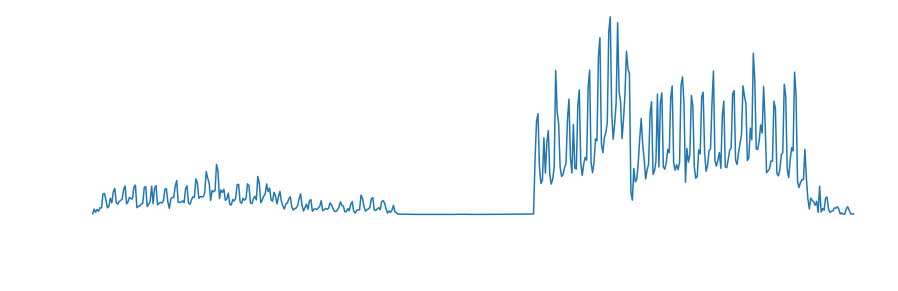

In [161]:
plt.rcParams["figure.figsize"] = (15,4)
sns.lineplot(data=air_reserve_visit_date_grouped, x='visit_date', y='reserve_visitors')
plt.xticks(rotation=50)
plt.xlabel("Num of reservations made")
plt.show()

In [162]:
air_reserve_df['visit_hour'] = air_reserve_df['visit_datetime'].dt.hour
air_reserve_visit_hour_grouped = air_reserve_df.groupby('visit_hour', as_index=False).agg({'reserve_visitors':'sum'})

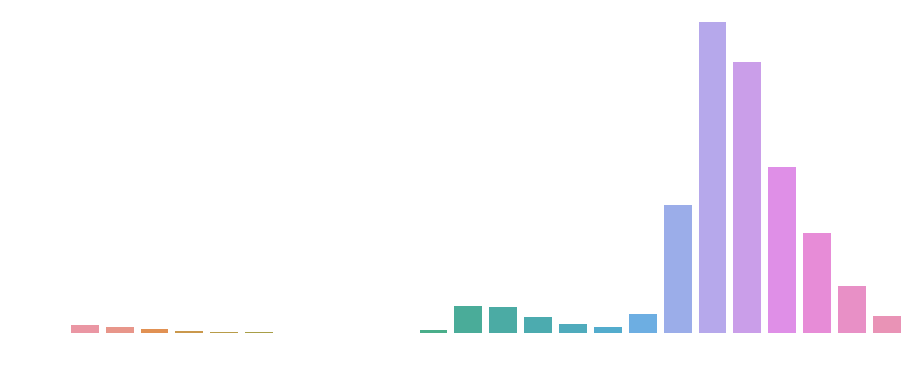

In [186]:
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=air_reserve_visit_hour_grouped, x='visit_hour', y='reserve_visitors')
plt.xlabel("Visiting hours")
plt.show()

In [168]:
air_reserve_df['diff_hour'] = (air_reserve_df['visit_datetime'] - air_reserve_df['reserve_datetime']).dt.total_seconds()/3600.0 #get the total hours of difference. 
air_reserve_df['diff_day'] = (air_reserve_df['visit_datetime'] - air_reserve_df['reserve_datetime']).dt.days

In [176]:
air_reserve_df['diff_hour'] = round(air_reserve_df['diff_hour'], 2)
air_reserve_df

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_hour,diff_hour,diff_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19,3.0,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19,0.0,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19,0.0,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20,4.0,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20,19.0,0
...,...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,18,1007.0,41
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,23,990.0,41
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,20,1173.0,48
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,20,1012.0,42


In [213]:
air_reserve_hour_diff_grouped = air_reserve_df.groupby('diff_hour', as_index=False).agg({'reserve_visitors':'sum'})

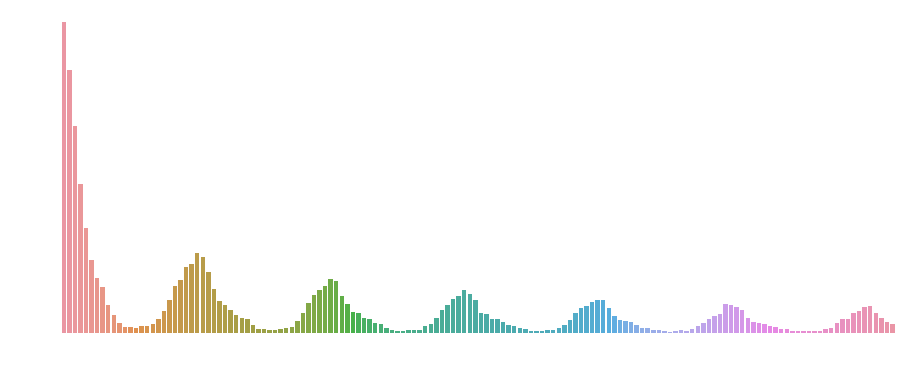

In [189]:
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=air_reserve_hour_diff_grouped[(air_reserve_hour_diff_grouped['diff_hour'] < 150.0)], x='diff_hour', y='reserve_visitors')
plt.xlabel("Hours from reservation to visit.")
plt.xticks(np.arange(0, 155, 10))
plt.show()

In [192]:
max_day, max_hour = air_reserve_hour_diff_grouped['diff_hour'].max()//24, air_reserve_hour_diff_grouped['diff_hour'].max() % 24
print(f"The maximum time between the reservation made and the visit made : {air_reserve_hour_diff_grouped['diff_hour'].max()} or {max_day} days and {max_hour} hours.")

The maximum time between the reservation made and the visit made : 9435.0 or 393.0 days and 3.0 hours.


In [197]:
top_ten_diff_hour = air_reserve_df.sort_values(by='diff_hour', ascending=False).head(10)
top_ten_diff_hour

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_hour,diff_hour,diff_day
59263,air_e7fbee4e3cfe65c5,2017-02-07 20:00:00,2016-01-11 17:00:00,20,2017-02-07,20,9435.0,393
59257,air_e7fbee4e3cfe65c5,2017-02-07 20:00:00,2016-01-12 20:00:00,3,2017-02-07,20,9408.0,392
59262,air_e7fbee4e3cfe65c5,2017-02-07 20:00:00,2016-01-18 18:00:00,5,2017-02-07,20,9266.0,386
50826,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 00:00:00,4,2017-01-18,20,9188.0,382
50805,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 20:00:00,2,2017-01-18,20,9168.0,382
50809,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 21:00:00,6,2017-01-18,20,9167.0,381
50774,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-03 12:00:00,4,2017-01-18,20,9152.0,381
59173,air_e7fbee4e3cfe65c5,2017-02-07 19:00:00,2016-01-23 18:00:00,2,2017-02-07,19,9145.0,381
50813,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-05 16:00:00,2,2017-01-18,20,9100.0,379
59267,air_e7fbee4e3cfe65c5,2017-02-07 20:00:00,2016-01-25 21:00:00,4,2017-02-07,20,9095.0,378


In [198]:
top_ten_diff_hour['air_store_id'].unique()

array(['air_e7fbee4e3cfe65c5', 'air_2a485b92210c98b5'], dtype=object)

From the visualizations, we can see that:

* We can see that the usage of reservation system kicked off around the beginning of year 2017. The decline at the end seems artificial and probably was made so for the training timeframe.
* Num of reservations made peaks around the evening time. 
* Many of the reservations are made few hours before their visit. However, if the reservations were made much prior, people tend to book exactly around the evenings. There are also reservations made more than a year prior. Note that the top 10 reservations were all made for 2 restaurants only. Either this is a fault in data entry or it's a really fancy restaurants where reservations has to be made way prior to the date.

#### <a id='toc1_2_3_3_'></a>[HPG Reservations](#toc0_)

In [203]:
hpg_reserve_df['visit_date'] = hpg_reserve_df['visit_datetime'].dt.date
hpg_reserve_date_grouped = hpg_reserve_df.groupby('visit_date', as_index=False).agg({"reserve_visitors":"sum"})

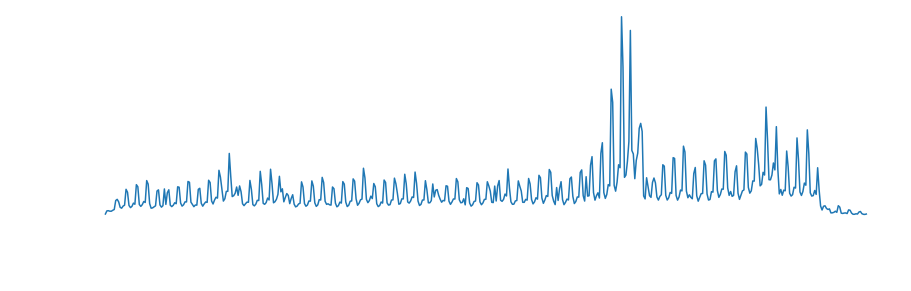

In [209]:
plt.rcParams["figure.figsize"] = (15,4)
sns.lineplot(data=hpg_reserve_date_grouped, x='visit_date', y='reserve_visitors')
plt.xticks(rotation=50)
plt.xlabel("Num of reservations made in HPG")
plt.show()

In [211]:
hpg_reserve_df['visit_hour'] = hpg_reserve_df['visit_datetime'].dt.hour
hpg_reserve_visit_hour_grouped = hpg_reserve_df.groupby('visit_hour', as_index=False).agg({'reserve_visitors':'sum'})

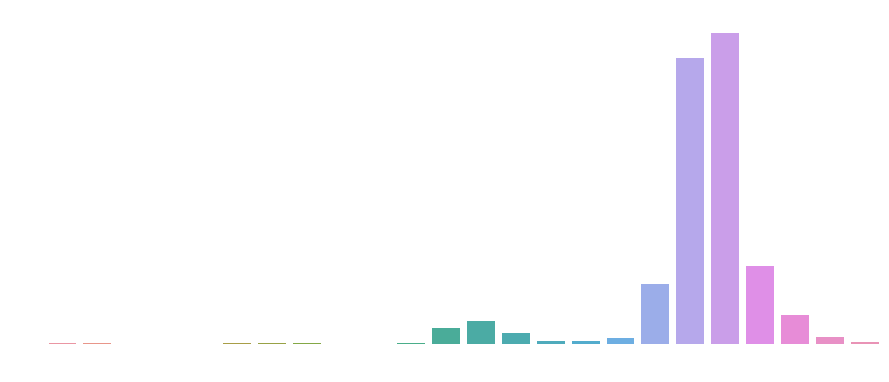

In [212]:
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=hpg_reserve_visit_hour_grouped, x='visit_hour', y='reserve_visitors')
plt.xlabel("Visiting hours")
plt.show()

In [215]:
hpg_reserve_df['diff_hour'] = (hpg_reserve_df['visit_datetime'] - hpg_reserve_df['reserve_datetime']).dt.total_seconds()/3600.0 #get the total hours of difference. 
hpg_reserve_df['diff_day'] = (hpg_reserve_df['visit_datetime'] - hpg_reserve_df['reserve_datetime']).dt.days

In [216]:
hpg_reserve_df['diff_hour'] = round(hpg_reserve_df['diff_hour'], 2)
hpg_reserve_df

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_hour,diff_hour,diff_day
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11,2.0,0
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13,7.0,0
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16,2.0,0
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,17,6.0,0
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,17,14.0,0
...,...,...,...,...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2,2017-05-31,20,1021.0,42
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3,2017-05-31,20,1772.0,73
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49,2017-05-31,21,1129.0,47
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9,2017-05-31,21,1012.0,42


In [217]:
hpg_reserve_hour_diff_grouped = hpg_reserve_df.groupby('diff_hour', as_index=False).agg({'reserve_visitors':'sum'})

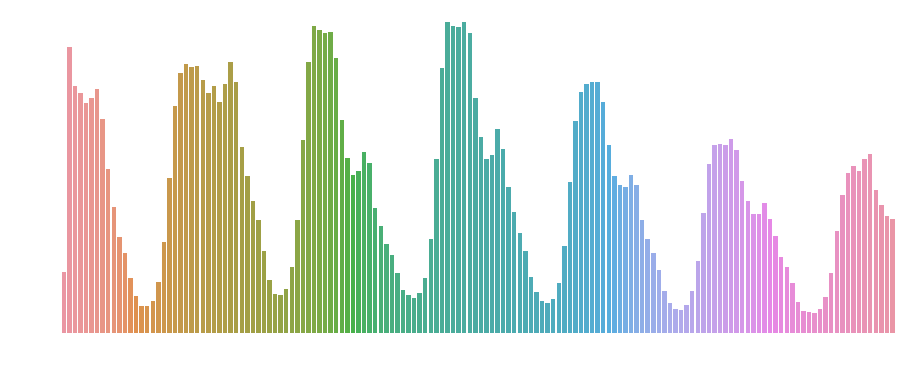

In [218]:
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=hpg_reserve_hour_diff_grouped[(hpg_reserve_hour_diff_grouped['diff_hour'] < 150.0)], x='diff_hour', y='reserve_visitors')
plt.xlabel("Hours from reservation to visit.")
plt.xticks(np.arange(0, 155, 10))
plt.show()

In [219]:
top_ten_diff_hour = hpg_reserve_df.sort_values(by='diff_hour', ascending=False).head(10)
top_ten_diff_hour

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_hour,diff_hour,diff_day
1605287,hpg_27220c59393af3ff,2017-02-23 19:00:00,2016-02-21 16:00:00,2,2017-02-23,19,8835.0,368
1847912,hpg_f1e9bb84d62ac5e6,2017-04-01 19:00:00,2016-04-04 19:00:00,5,2017-04-01,19,8688.0,362
1378427,hpg_f1263e620d5a1700,2017-01-08 21:00:00,2016-06-27 21:00:00,2,2017-01-08,21,4680.0,195
1331229,hpg_f515074aed165305,2016-12-30 18:00:00,2016-07-19 09:00:00,6,2016-12-30,18,3945.0,164
657254,hpg_e24c39077f7000ef,2016-08-14 14:00:00,2016-03-11 10:00:00,4,2016-08-14,14,3748.0,156
1997425,hpg_b8f2e7cc5536ca58,2017-05-13 17:00:00,2016-12-25 19:00:00,70,2017-05-13,17,3334.0,138
646911,hpg_2afd5b187409eeb4,2016-08-11 23:00:00,2016-03-31 01:00:00,2,2016-08-11,23,3214.0,133
903508,hpg_2afd5b187409eeb4,2016-10-26 22:00:00,2016-06-20 23:00:00,2,2016-10-26,22,3071.0,127
863096,hpg_bb7108f96e60cb52,2016-10-15 17:00:00,2016-06-12 18:00:00,8,2016-10-15,17,2999.0,124
630798,hpg_862feb6f21135b09,2016-08-06 21:00:00,2016-04-07 00:00:00,5,2016-08-06,21,2925.0,121


In [221]:
top_ten_diff_hour['hpg_store_id'].unique()

array(['hpg_27220c59393af3ff', 'hpg_f1e9bb84d62ac5e6',
       'hpg_f1263e620d5a1700', 'hpg_f515074aed165305',
       'hpg_e24c39077f7000ef', 'hpg_b8f2e7cc5536ca58',
       'hpg_2afd5b187409eeb4', 'hpg_bb7108f96e60cb52',
       'hpg_862feb6f21135b09'], dtype=object)

As for for HPG reservation system, we find that:

* The number of reservations made throughout the timeline is more consistent than the previous air reservation system. There is a clear spike however around the end of 2016.
* Most reservations again are for dinner time.
* It seems like the reservations made from HPG is a lot more than the one made from the Air system. The reservations made here are also usually be made around dinner time. However, unlike the previous air data, the number of reservations made actually peaks around 3 days before the visit. 

### <a id='toc1_2_4_'></a>[Spatial Analysis](#toc0_)

#### <a id='toc1_2_4_1_'></a>[Air Store](#toc0_)

In [348]:
japan_air_map = folium.Map(location=[35.65, 139.83], tiles='Stamen Terrain', zoom_start=6, control_scale=True)
#air_store_df.apply(lambda row: folium.plugins.MarkerCluster(location=[row['latitude'], row['longitude']]).add_to(japan_map), axis=1)

#Documentation here: https://github.com/Leaflet/Leaflet.markercluster#bulk-adding-and-removing-markers
callback = ('function (row) {' 
                'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red",  radius: 1000});'
                'var popup = L.popup({maxWidth: "300"});'
                'const display_text = {text: row["2"] + ", " + row["3"]};'
                'var mytext = $(`<div id="mytext" class="display_text" style="width: 100.0%; height: 100.0%;"> ${display_text.text}</div>`)[0];'
                'popup.setContent(mytext);'
                'marker.bindPopup(popup);'
                'return marker};')

japan_air_map.add_child(FastMarkerCluster(air_store_df[['latitude', 'longitude', 'air_store_id', 'air_genre_name']].values.tolist(), callback=callback))
japan_air_map

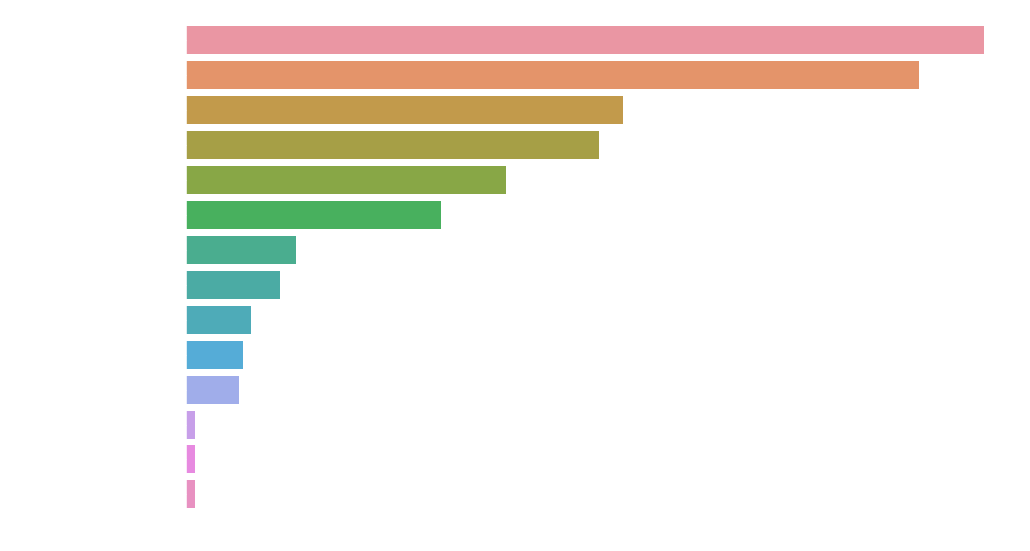

In [344]:
air_store_genre_group = air_store_df.groupby('air_genre_name', as_index=False).agg(air_count=('air_genre_name', 'count')).sort_values('air_count', ascending=False)
sns.barplot(data=air_store_genre_group, x='air_count', y='air_genre_name', order=air_store_genre_group['air_genre_name'])
plt.title("Restaurant genre count (Air).", color='w')
plt.show()

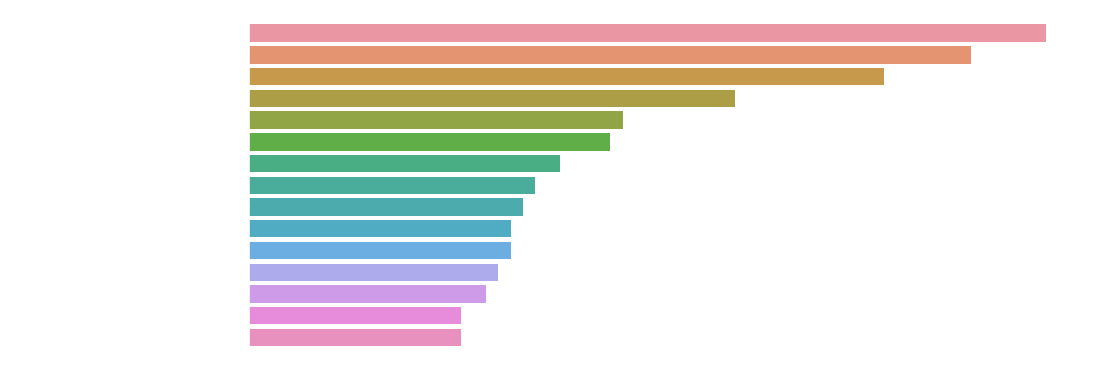

In [335]:
air_store_area_group = air_store_df.groupby('air_area_name', as_index=False).agg(area_count=('air_area_name', 'count')).sort_values('area_count', ascending=False)
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=air_store_area_group[:15], x='area_count', y='air_area_name', order=air_store_area_group['air_area_name'][:15])
plt.title("Top 15 areas with highest num of restaurants.", color='w')
plt.show()

* It seems like Izakaya genred restaurants dominates our dataset followed by cafes. Karaoke and international restaurants are the fewest part of the dataset.
- An izakaya (居酒屋) (Japanese: [izakaja]) is a type of informal Japanese bar that serves alcoholic drinks and snacks. Izakaya are casual places for after-work drinking, similar to a pub, a Spanish tapas bar, or an American saloon or tavern.
* Fukuoka area has the highest number of restaurants per area and there's many tokyo-based areas in the list as well. Makes sense since Tokyo is densely populated.

In [337]:
hpg_store_df

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742


#### HPG Store

In [338]:
japan_hpg_map = folium.Map(location=[35.65, 139.83], tiles='Stamen Terrain', zoom_start=6, control_scale=True)
#air_store_df.apply(lambda row: folium.plugins.MarkerCluster(location=[row['latitude'], row['longitude']]).add_to(japan_map), axis=1)

#Documentation here: https://github.com/Leaflet/Leaflet.markercluster#bulk-adding-and-removing-markers
callback = ('function (row) {' 
                'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red",  radius: 1000});'
                'var popup = L.popup({maxWidth: "300"});'
                'const display_text = {text: row["2"] + ", " + row["3"]};'
                'var mytext = $(`<div id="mytext" class="display_text" style="width: 100.0%; height: 100.0%;"> ${display_text.text}</div>`)[0];'
                'popup.setContent(mytext);'
                'marker.bindPopup(popup);'
                'return marker};')

japan_hpg_map.add_child(FastMarkerCluster(hpg_store_df[['latitude', 'longitude', 'hpg_store_id', 'hpg_genre_name']].values.tolist(), callback=callback))
japan_hpg_map

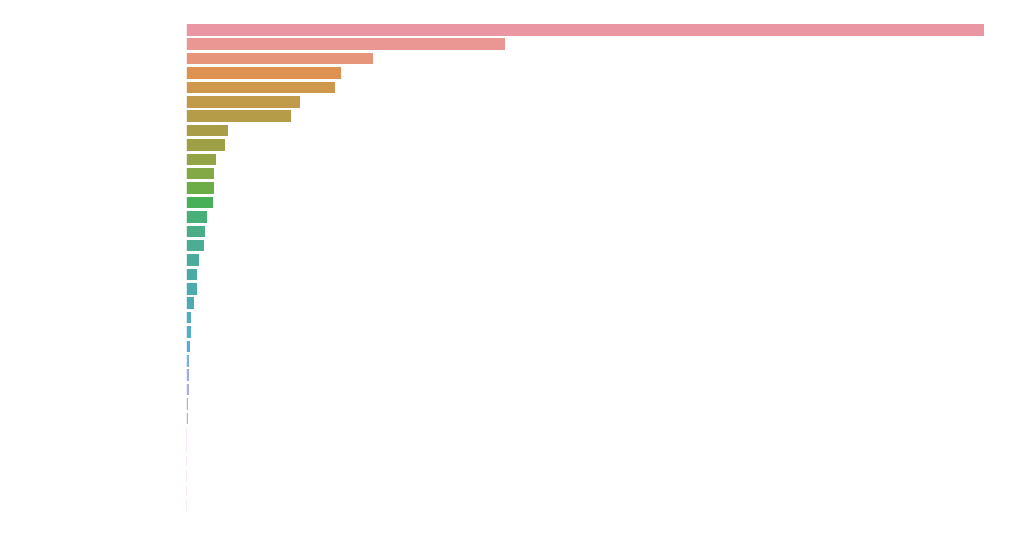

In [349]:
plt.rcParams["figure.figsize"] = (15,9)
hpg_store_genre_group = hpg_store_df.groupby('hpg_genre_name', as_index=False).agg(hpg_count=('hpg_genre_name', 'count')).sort_values('hpg_count', ascending=False)
sns.barplot(data=hpg_store_genre_group, x='hpg_count', y='hpg_genre_name', order=hpg_store_genre_group['hpg_genre_name'])
plt.title("Restaurant genre count (HPG).", color='w')
plt.show()

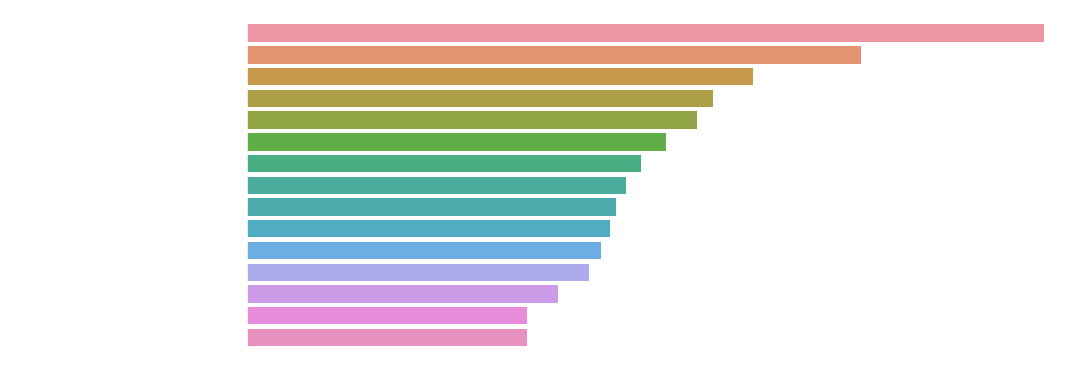

In [347]:
hpg_store_area_group = hpg_store_df.groupby('hpg_area_name', as_index=False).agg(area_count=('hpg_area_name', 'count')).sort_values('area_count', ascending=False)
plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(data=hpg_store_area_group[:15], x='area_count', y='hpg_area_name', order=hpg_store_area_group['hpg_area_name'][:15])
plt.title("Top 15 areas with highest num of restaurants.", color='w')
plt.show()

* In the HPG data, we find that japanese style food and international food dominates the genre. There are also way more genres than the air data.
* Again there are more restaurants in Tokyo and Osaka compared to the rest of the places. 